In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install -q timm

In [1]:
from huggingface_hub import hf_hub_download
from PIL import Image
from transformers import DetrFeatureExtractor
from transformers import TableTransformerForObjectDetection
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{model.config.id2label[label]}: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

2023-05-02 17:12:50.283004: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 17:12:51.239414: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Table Detection

/opt/conda/lib/python3.9/site-packages/transformers/models/detr/feature_extraction_detr.py:28: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


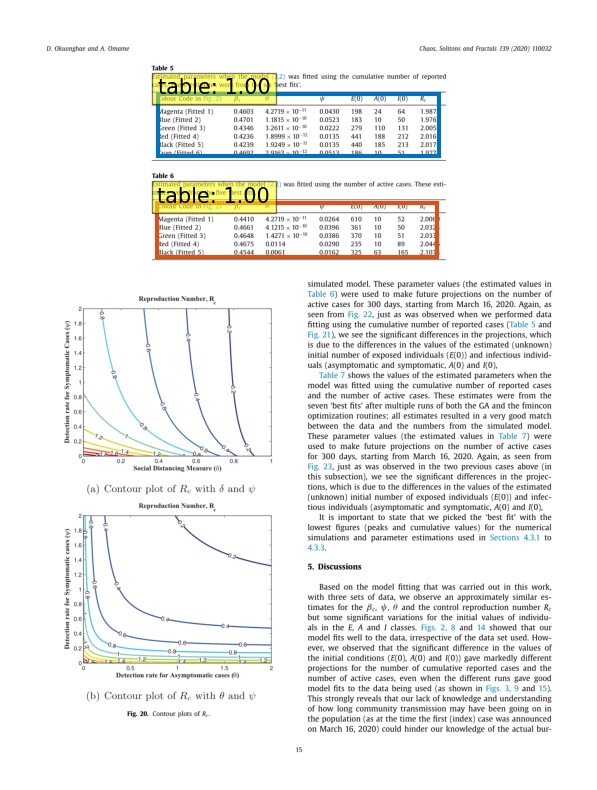

In [2]:
# Load a PDF page as an image
image = Image.open('5ef119afa58f1dfd5209bd33-15.png').convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

# Apply the regular image preprocessing using `DetrFeatureExtractor`. 
# The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.
feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")

# Load the model from the hub, send the pixel values and pixel mask through the model, and perform a forward pass.
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")
with torch.no_grad():
    outputs = model(**encoding)

# rescale bounding boxes
width, height = image.size
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

# visualization
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [3]:
results['boxes'] # x1, y1, x2, y2

tensor([[ 422.6438,  241.1607, 1227.7239,  417.1541],
        [ 421.5742,  552.7244, 1223.2365,  708.1834]])

## Table structure recognition: identifying the several rows, columns, cells in a table.

In [4]:
# Load a PDF page as an image
image = Image.open('5ef119afa58f1dfd5209bd33-15-crop.png').convert("RGB")
width, height = image.size
image.resize((int(width*0.5), int(height*0.5)))

# Apply the regular image preprocessing using `DetrFeatureExtractor`. 
# The feature extractor will resize the image (minimum size = 800, max size = 1333), and normalize it across the channels using the ImageNet mean and standard deviation.
feature_extractor = DetrFeatureExtractor()
encoding = feature_extractor(image, return_tensors="pt")

# Load the model from the hub, send the pixel values and pixel mask through the model, and perform a forward pass.
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")
with torch.no_grad():
    outputs = model(**encoding)

# rescale bounding boxes
target_sizes = [image.size[::-1]]
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

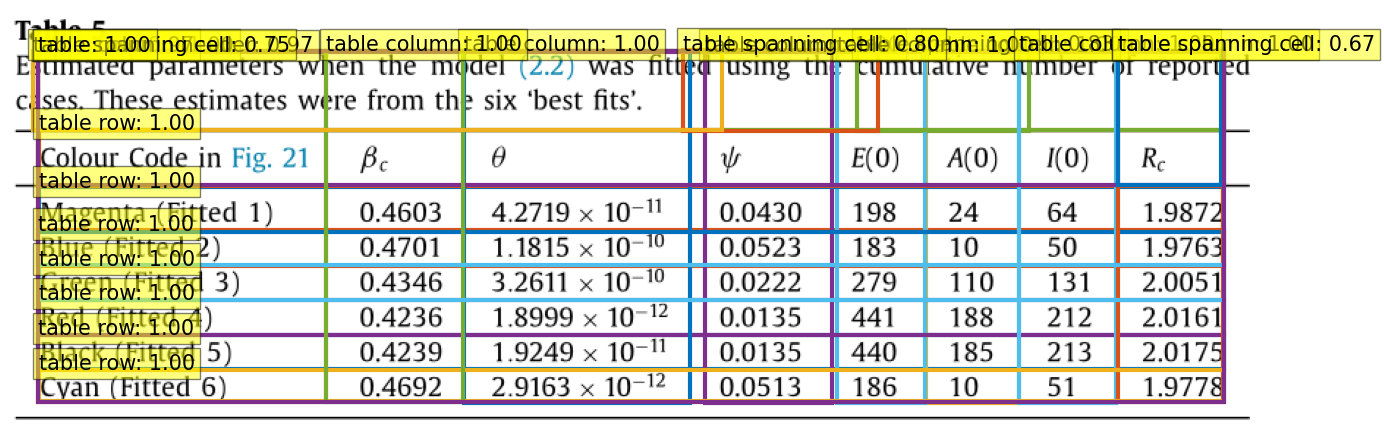

In [5]:
# visualization
plot_results(image, results['scores'], results['labels'], results['boxes'])


In [6]:
model.config.id2label

{0: 'table',
 1: 'table column',
 2: 'table row',
 3: 'table column header',
 4: 'table projected row header',
 5: 'table spanning cell'}